#1. Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#2. Setup Path Dataset

In [ ]:
train_dir = '/content/drive/MyDrive/dataset-gila/dataset-training-500'
valtest_dir = '/content/drive/MyDrive/dataset-gila/dataset-valtest'

val_dir = '/content/val_split/val'
test_dir = '/content/val_split/test'


Dataset asli yang diambil langsung di pulau penyengat kami augmentasi menjadi 500 gambar per-kelas dengan folder utama bernama dataset-training-500 yang nantinya menjadi data training.

Kami mengumpulkan berbagai data baru gambar dari internet tiap tiap kelasnya, yang kemudian data baru dari internet tersebut nantinya akan menjadi data validasi dan data testing (dataset-valtest)

#3. Split valtest jadi Val & Test

In [ ]:
import os, shutil
from sklearn.model_selection import train_test_split

os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(valtest_dir):
    class_path = os.path.join(valtest_dir, class_name)
    if not os.path.isdir(class_path): continue

    images = os.listdir(class_path)
    train_imgs, test_imgs = train_test_split(images, test_size=0.5, random_state=42)

    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))


Membagi dua dataset-valtest menjadi 50:50. 50% menjadi data validasi dan 50% menjadi data testing.

#4. Data Generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=[0.85, 1.15],
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

valtest_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical')
val_gen = valtest_datagen.flow_from_directory(val_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test_gen = valtest_datagen.flow_from_directory(test_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

print("Train classes:", train_gen.class_indices)
print("Val classes:", val_gen.class_indices)
print("Test classes:", test_gen.class_indices)



Found 3501 images belonging to 7 classes.
Found 350 images belonging to 7 classes.
Found 350 images belonging to 7 classes.
Train classes: {'balai-adat-melayu': 0, 'gedung-tabib': 1, 'makam-engku-putri': 2, 'makam-raja-ali-haji': 3, 'masjid-raya-sultan-riau': 4, 'meriam-bukit-kursi': 5, 'rumah-hakim': 6}
Val classes: {'balai-adat-melayu': 0, 'gedung-tabib': 1, 'makam-engku-putri': 2, 'makam-raja-ali-haji': 3, 'masjid-raya-sultan-riau': 4, 'meriam-bukit-kursi': 5, 'rumah-hakim': 6}
Test classes: {'balai-adat-melayu': 0, 'gedung-tabib': 1, 'makam-engku-putri': 2, 'makam-raja-ali-haji': 3, 'masjid-raya-sultan-riau': 4, 'meriam-bukit-kursi': 5, 'rumah-hakim': 6}


**Prepocessing Gambar**

Sebelum proses traing nantinya dipersiapkan dulu data yang akan digunakan. Semua ukuran gambar yang ada sizenya 224x224 dengan batch size 32.

Dengan menggunakan ImageDataGenerator dari TensorFlow.

> Pada train_datagen: Digunakan untuk augmentasi data pelatihan, yang bertujuan meningkatkan variasi gambar dan mencegah overfitting. Beberapa augmentasi yang diterapkan:
* rotation_range: Memutar gambar hingga 10 derajat.
* zoom_range: Melakukan zoom in/out pada gambar dengan skala 10%.
* brightness_range: Mengubah kecerahan gambar dalam rentang 85% hingga 115%.
* width_shift_range & height_shift_range: Menggeser gambar secara horizontal dan vertikal hingga 5%.
* horizontal_flip: Membalik gambar secara horizontal.

> Pada valtest_datagen: Hanya melakukan normalisasi gambar dengan rescale=1./255 tanpa augmentasi untuk data validasi dan uji, karena biasanya data tersebut harus tetap representatif.

Dataset ini terdiri dari 3501 gambar untuk pelatihan, 350 gambar untuk validasi, dan 350 gambar untuk pengujian, dengan 7 kelas yang berbeda. Setiap kelas mewakili situs bersejarah atau bangunan, dan distribusi kelasnya seragam antara data pelatihan, validasi, dan pengujian. Hal ini menunjukkan bahwa dataset memiliki pembagian yang seimbang, yang dapat membantu model dalam belajar secara efektif dan mengurangi potensi bias dalam pelatihan.

#5. Hyperparameter & Build Model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam


# 🔧 Configurable
LEARNING_RATE = 1e-6
FROZEN_PERCENT = 0.3
MIN_LR = 1e-7

# Base Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ❄️ Freeze sebagian layer
num_layers = len(base_model.layers)
num_frozen = int(FROZEN_PERCENT * num_layers)
for layer in base_model.layers[:num_frozen]:
    layer.trainable = False

# Add classifier
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


>Base Model (MobileNetV2):
* Menggunakan MobileNetV2 yang telah dilatih pada dataset ImageNet, dan hanya mengambil fitur ekstraksi (tanpa bagian klasifikasi dengan include_top=False).
* Input gambar diproses dengan ukuran 224x224 dan 3 saluran warna (RGB).

> Pembekuan (Freeze) Layer:
* Hanya sebagian dari layer MobileNetV2 yang akan dilatih ulang, sesuai dengan FROZEN_PERCENT, 30% dari layer pertama dibekukan dan tidak dilatih.
* Ini dilakukan untuk mempertahankan fitur dasar yang telah dipelajari oleh MobileNetV2 dan mempercepat pelatihan model.

> Menambahkan Klasifikator:
* Setelah bagian ekstraksi fitur dari MobileNetV2, digunakan GlobalAveragePooling2D() untuk mereduksi dimensi.
* Kemudian, layer Dense ditambahkan sebagai layer output dengan jumlah kelas yang sesuai dengan train_gen.num_classes, menggunakan fungsi aktivasi softmax untuk klasifikasi multi-kelas.

> Kompilasi Model:
* Model dikompilasi dengan optimasi menggunakan Adam dengan learning rate yang sangat kecil (1e-6) dan menggunakan categorical_crossentropy sebagai fungsi loss untuk klasifikasi multi-kelas.

Dengan menggunakan MobileNetV2 yang sudah dilatih sebelumnya dan hanya melatih layer akhir, model ini bisa lebih cepat dan efisien dalam pelatihan, apalagi dengan menggunakan learning rate kecil. Teknik ini disebut transfer learning, yang sangat berguna ketika data terbatas atau membutuhkan model yang sudah terlatih sebelumnya.

#6. Callbacks: Early Stop, ReduceLR, Save Best

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = '/content/drive/MyDrive/modelku/bocchichan_model_best.h5'

callbacks = [
    #EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=MIN_LR)
]


> ModelCheckpoint:
* Tujuan: Menyimpan model terbaik (dengan performa terbaik pada val_loss) selama pelatihan ke dalam file bocchichan_model_best.h5.
* Fungsi: Model hanya disimpan jika nilai val_loss lebih baik dari sebelumnya (menggunakan save_best_only=True).

> ReduceLROnPlateau:
* Tujuan: Mengurangi learning rate jika val_loss tidak membaik setelah beberapa epoch.
* Fungsi: Jika val_loss tidak membaik dalam 2 epoch (ditentukan oleh patience=2), maka learning rate akan dikurangi setengah (factor=0.5). Proses ini membantu model keluar dari local minima dan mempercepat konvergensi.

Callback ini sangat berguna untuk menghindari overfitting, menjaga model tetap optimal (dengan ModelCheckpoint), dan menyesuaikan kecepatan pelatihan model (dengan ReduceLROnPlateau). Mereka membantu pelatihan menjadi lebih efisien dan mencegah model overfit atau terjebak di minima lokal.

#7. Training

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.1992 - loss: 2.0337 

110/110 ━━━━━━━━━━━━━━━━━━━━ 2036s 18s/step - accuracy: 0.1995 - loss: 2.0330 - val_accuracy: 0.1971 - val_loss: 2.0783 - learning_rate: 1.0000e-06
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.3454 - loss: 1.7250

110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 591ms/step - accuracy: 0.3457 - loss: 1.7243 - val_accuracy: 0.2429 - val_loss: 1.9238 - learning_rate: 1.0000e-06
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.5170 - loss: 1.4150

110/110 ━━━━━━━━━━━━━━━━━━━━ 64s 580ms/step - accuracy: 0.5172 - loss: 1.4146 - val_accuracy: 0.3143 - val_loss: 1.7811 - learning_rate: 1.0000e-06
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.6257 - loss: 1.2153

110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 589ms/step - accuracy: 0.6259 - loss: 1.2148 - val_accuracy: 0.4029 - val_loss: 1.6485 - learning_rate: 1.0000e-06
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.7227 - loss: 1.0279

110/110 ━━━━━━━━━━━━━━━━━━━━ 66s 596ms/step - accuracy: 0.7230 - loss: 1.0275 - val_accuracy: 0.4543 - val_loss: 1.5287 - learning_rate: 1.0000e-06
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.8032 - loss: 0.8646

110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 588ms/step - accuracy: 0.8034 - loss: 0.8643 - val_accuracy: 0.4914 - val_loss: 1.4199 - learning_rate: 1.0000e-06
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8571 - loss: 0.7300

110/110 ━━━━━━━━━━━━━━━━━━━━ 82s 592ms/step - accuracy: 0.8572 - loss: 0.7300 - val_accuracy: 0.5314 - val_loss: 1.3245 - learning_rate: 1.0000e-06
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.8927 - loss: 0.6352

110/110 ━━━━━━━━━━━━━━━━━━━━ 64s 581ms/step - accuracy: 0.8927 - loss: 0.6350 - val_accuracy: 0.5657 - val_loss: 1.2386 - learning_rate: 1.0000e-06
Epoch 9/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9031 - loss: 0.5777

110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 583ms/step - accuracy: 0.9032 - loss: 0.5774 - val_accuracy: 0.5971 - val_loss: 1.1628 - learning_rate: 1.0000e-06
Epoch 10/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9286 - loss: 0.4854

110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 589ms/step - accuracy: 0.9286 - loss: 0.4854 - val_accuracy: 0.6314 - val_loss: 1.0961 - learning_rate: 1.0000e-06
Epoch 11/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9406 - loss: 0.4357

110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 590ms/step - accuracy: 0.9406 - loss: 0.4355 - val_accuracy: 0.6657 - val_loss: 1.0361 - learning_rate: 1.0000e-06
Epoch 12/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9528 - loss: 0.3837

110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 586ms/step - accuracy: 0.9528 - loss: 0.3836 - val_accuracy: 0.6800 - val_loss: 0.9824 - learning_rate: 1.0000e-06
Epoch 13/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9505 - loss: 0.3439

110/110 ━━━━━━━━━━━━━━━━━━━━ 63s 570ms/step - accuracy: 0.9505 - loss: 0.3438 - val_accuracy: 0.7000 - val_loss: 0.9329 - learning_rate: 1.0000e-06
Epoch 14/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9619 - loss: 0.3121

110/110 ━━━━━━━━━━━━━━━━━━━━ 63s 573ms/step - accuracy: 0.9619 - loss: 0.3120 - val_accuracy: 0.7229 - val_loss: 0.8896 - learning_rate: 1.0000e-06
Epoch 15/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9672 - loss: 0.2808

110/110 ━━━━━━━━━━━━━━━━━━━━ 64s 579ms/step - accuracy: 0.9672 - loss: 0.2808 - val_accuracy: 0.7343 - val_loss: 0.8489 - learning_rate: 1.0000e-06
Epoch 16/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9695 - loss: 0.2559

110/110 ━━━━━━━━━━━━━━━━━━━━ 63s 577ms/step - accuracy: 0.9695 - loss: 0.2558 - val_accuracy: 0.7486 - val_loss: 0.8126 - learning_rate: 1.0000e-06
Epoch 17/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9714 - loss: 0.2334

110/110 ━━━━━━━━━━━━━━━━━━━━ 63s 572ms/step - accuracy: 0.9714 - loss: 0.2334 - val_accuracy: 0.7600 - val_loss: 0.7790 - learning_rate: 1.0000e-06
Epoch 18/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9822 - loss: 0.2013

110/110 ━━━━━━━━━━━━━━━━━━━━ 66s 596ms/step - accuracy: 0.9821 - loss: 0.2012 - val_accuracy: 0.7771 - val_loss: 0.7481 - learning_rate: 1.0000e-06
Epoch 19/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9808 - loss: 0.1805

110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 593ms/step - accuracy: 0.9809 - loss: 0.1805 - val_accuracy: 0.7829 - val_loss: 0.7207 - learning_rate: 1.0000e-06
Epoch 20/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9836 - loss: 0.1706

110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 589ms/step - accuracy: 0.9836 - loss: 0.1706 - val_accuracy: 0.7800 - val_loss: 0.6965 - learning_rate: 1.0000e-06
Epoch 21/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9853 - loss: 0.1484

110/110 ━━━━━━━━━━━━━━━━━━━━ 63s 576ms/step - accuracy: 0.9853 - loss: 0.1484 - val_accuracy: 0.7971 - val_loss: 0.6727 - learning_rate: 1.0000e-06
Epoch 22/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9866 - loss: 0.1465

110/110 ━━━━━━━━━━━━━━━━━━━━ 62s 564ms/step - accuracy: 0.9866 - loss: 0.1464 - val_accuracy: 0.8000 - val_loss: 0.6514 - learning_rate: 1.0000e-06
Epoch 23/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9875 - loss: 0.1333

110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 575ms/step - accuracy: 0.9875 - loss: 0.1333 - val_accuracy: 0.8143 - val_loss: 0.6309 - learning_rate: 1.0000e-06
Epoch 24/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9891 - loss: 0.1206

110/110 ━━━━━━━━━━━━━━━━━━━━ 63s 576ms/step - accuracy: 0.9891 - loss: 0.1206 - val_accuracy: 0.8200 - val_loss: 0.6116 - learning_rate: 1.0000e-06
Epoch 25/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9882 - loss: 0.1214

110/110 ━━━━━━━━━━━━━━━━━━━━ 82s 577ms/step - accuracy: 0.9882 - loss: 0.1213 - val_accuracy: 0.8314 - val_loss: 0.5930 - learning_rate: 1.0000e-06
Epoch 26/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9919 - loss: 0.1046

110/110 ━━━━━━━━━━━━━━━━━━━━ 64s 583ms/step - accuracy: 0.9919 - loss: 0.1045 - val_accuracy: 0.8400 - val_loss: 0.5767 - learning_rate: 1.0000e-06
Epoch 27/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9925 - loss: 0.0892

110/110 ━━━━━━━━━━━━━━━━━━━━ 82s 588ms/step - accuracy: 0.9925 - loss: 0.0892 - val_accuracy: 0.8514 - val_loss: 0.5614 - learning_rate: 1.0000e-06
Epoch 28/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9931 - loss: 0.0857

110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 588ms/step - accuracy: 0.9931 - loss: 0.0857 - val_accuracy: 0.8514 - val_loss: 0.5472 - learning_rate: 1.0000e-06
Epoch 29/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.9946 - loss: 0.0844

110/110 ━━━━━━━━━━━━━━━━━━━━ 62s 567ms/step - accuracy: 0.9946 - loss: 0.0844 - val_accuracy: 0.8629 - val_loss: 0.5327 - learning_rate: 1.0000e-06
Epoch 30/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9973 - loss: 0.0711

110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 595ms/step - accuracy: 0.9972 - loss: 0.0712 - val_accuracy: 0.8657 - val_loss: 0.5197 - learning_rate: 1.0000e-06


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step
                         precision    recall  f1-score   support

      balai-adat-melayu       0.87      0.52      0.65        50
           gedung-tabib       0.75      0.82      0.78        50
      makam-engku-putri       0.92      0.90      0.91        50
    makam-raja-ali-haji       0.89      0.96      0.92        50
masjid-raya-sultan-riau       0.81      0.94      0.87        50
     meriam-bukit-kursi       0.82      0.98      0.89        50
            rumah-hakim       0.89      0.78      0.83        50

               accuracy                           0.84       350
              macro avg       0.85      0.84      0.84       350
           weighted avg       0.85      0.84      0.84       350



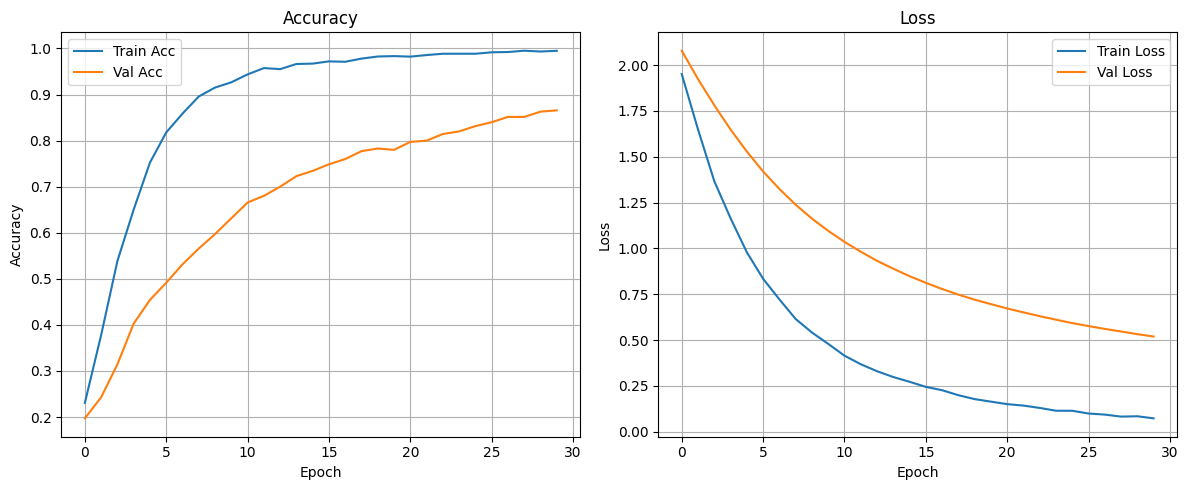

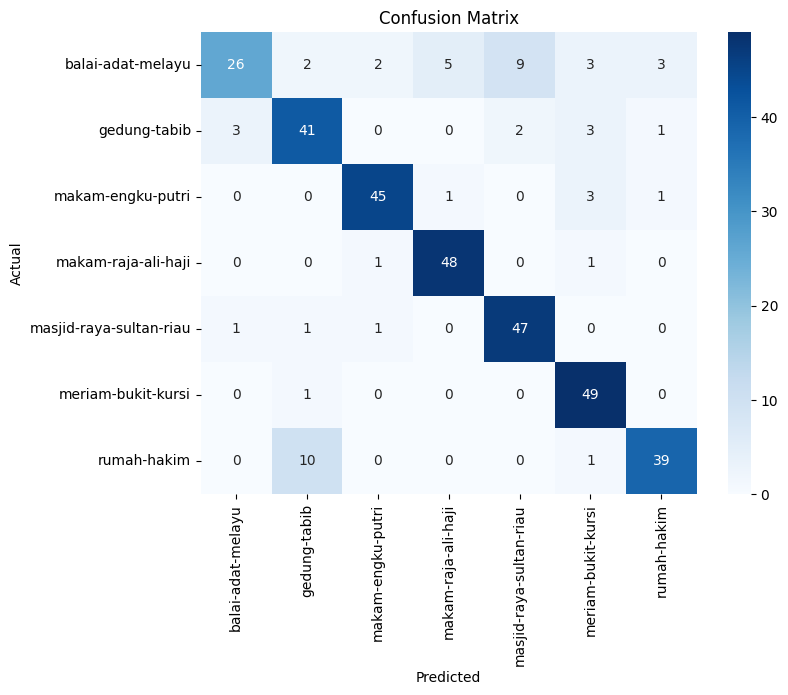

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)


# Simpan model full (untuk training lanjutan)
model.save('/content/drive/MyDrive/modelku/bocchichan_model_full.h5', include_optimizer=True)

# Simpan model inference (untuk deployment)
model.save('/content/drive/MyDrive/modelku/bocchichan_model_inference.h5', include_optimizer=False)


test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_history(history)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

> Melatih Model:
* model.fit(): Model dilatih selama 30 epoch dengan data pelatihan (train_gen) dan data validasi (val_gen). Selama pelatihan, beberapa callback yang telah didefinisikan sebelumnya (seperti ModelCheckpoint dan ReduceLROnPlateau) digunakan untuk mengoptimalkan pelatihan.

> Menyimpan Model:
Model disimpan dalam dua versi:
* bocchichan_model_full.h5: Model lengkap, termasuk optimizer, yang dapat digunakan untuk melanjutkan pelatihan.
* bocchichan_model_inference.h5: Model tanpa optimizer, siap digunakan untuk deployment/inference.

> Prediksi dengan Data Uji:
* model.predict(): Model digunakan untuk memprediksi kelas dari data uji (test_gen).
* np.argmax(): Mengambil kelas yang memiliki probabilitas tertinggi dari hasil prediksi.
* classification_report(): Menampilkan laporan klasifikasi yang berisi metrik evaluasi seperti precision, recall, dan F1-score untuk setiap kelas.

> Visualisasi:
* plot_history(): Fungsi untuk menggambar grafik akurasi dan loss selama pelatihan, baik untuk data pelatihan maupun validasi. Ini membantu melihat apakah model overfitting atau underfitting.
* Confusion Matrix: Menghitung dan menggambarkan matriks kebingunguan untuk memvisualisasikan prediksi vs kelas sebenarnya. Ini memberi gambaran tentang seberapa baik model dalam mengklasifikasikan setiap kelas.

# ANALISIS HASIL

> Akurasi: Model memiliki akurasi 84%, yang berarti bahwa 84% prediksi pada data uji benar.

> Precision, Recall, dan F1-Score per Kelas:
* Precision: Menunjukkan seberapa banyak prediksi yang benar di antara semua prediksi yang dibuat untuk kelas tersebut. Kelas dengan precision tinggi adalah makam-engku-putri (0.92) dan makam-raja-ali-haji (0.89), yang berarti model sangat akurat dalam memprediksi gambar dari kelas ini.
* Recall: Menunjukkan seberapa banyak data aktual untuk kelas tersebut yang berhasil diprediksi dengan benar oleh model. Kelas dengan recall tinggi adalah meriam-bukit-kursi (0.98) dan masjid-raya-sultan-riau (0.94), menunjukkan bahwa model hampir tidak melewatkan gambar dari kelas ini.
* F1-Score: Merupakan rata-rata harmonis antara precision dan recall. Kelas dengan F1-score tinggi adalah makam-engku-putri (0.91) dan makam-raja-ali-haji (0.92), yang berarti model seimbang dalam hal precision dan recall pada kelas ini.

> Macro Avg dan Weighted Avg:
* Macro Avg: Rata-rata per kelas tanpa mempertimbangkan ukuran kelas, menghasilkan nilai 0.84 untuk recall dan 0.85 untuk precision.
* Weighted Avg: Rata-rata yang mempertimbangkan jumlah contoh per kelas, menghasilkan hasil yang sama (0.84 untuk recall dan 0.85 untuk precision), menunjukkan distribusi kelas yang seimbang.

>Insight:
* Model sudah cukup baik, tetapi ada kelas dengan recall rendah, seperti balai-adat-melayu (0.52), yang menunjukkan bahwa model sering gagal mengenali gambar dari kelas ini.
* F1-Score dan precision untuk sebagian besar kelas cukup tinggi, menunjukkan model memiliki performa yang baik dalam mengenali sebagian besar kelas.
* Diperlukan perbaikan pada kelas dengan recall rendah (seperti balai-adat-melayu), yang dapat dicapai dengan menambah data latih atau menggunakan teknik augmentasi untuk kelas tersebut.